<a href="https://colab.research.google.com/github/ajmd2/Jinling-Enlightenment/blob/main/Greedy_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import random

class MultiArmedBandit:
  def __init__(self,num_arms = 10):

    self.num_arms = num_arms
    self.probs = np.random.uniform(size = num_arms)
    self.rewards = [[1] for _ in range(num_arms)]

  def reset_rewards(self):
    # 重置奖励记录
    self.rewards = [[1] for _ in range(self.num_arms)]

  def try_and_play(self,choose_one_func):
    i = choose_one_func()
    reward = 1 if random.random() < self.probs[i] else 0
    self.rewards[i].append(reward)

  def get_result(self, choose_one_func, num_trials = 5000):

    for _ in range(num_trials):
      self.try_and_play(choose_one_func)

    target = self.probs.max()* num_trials
    result = sum(sum(i) for i in self.rewards) - self.num_arms
    self.reset_rewards()
    return target , result




In [41]:
bandit = MultiArmedBandit()

1. 普通贪婪算法

In [42]:
import random

def choose_one():
  if random.random() <0.01: # 小概率随机探索
    return random.randint(0,9)

  rewards_mean = [np.mean(i) for i in bandit.rewards]

  return np.argmax(rewards_mean)

output = bandit.get_result(choose_one)
output

(4790.644805233537, 4756)

2. Improved greedy algorithm

In [43]:
import random
def choose_one_plus():
  played_count = sum([len(i) for i in bandit.rewards])

  if random.random()<1 /played_count:
      return random.randint(0,9)

  rewards_mean = [np.mean(i) for i in bandit.rewards]

  return np.argmax(rewards_mean)

output = bandit.get_result(choose_one_plus)
output

(4790.644805233537, 4797)

3. 上置信界算法,UCB算法,多探索玩的少的机器

(理论说明见我的飞书笔记)
https://bcnvcmgbcklt.feishu.cn/docx/CTH8d8YVvomx1vxiuygcf5jLn3g?from=from_copylink

In [44]:
import random


# ucb 衡量的是每个老虎机的不确定性，不确定性越大，探索的价值越大
def choose_one_ucb():
  played_count = [len(i) for i in bandit.rewards]
  played_count = np.array(played_count)

  fenzi = played_count.sum()**0.5
  fenmu = played_count*2
  ucb = (fenzi / fenmu)** 0.5


  rewards_mean = np.array([np.mean(i) for i in bandit.rewards])

  ucb += rewards_mean

  return ucb.argmax()

output = bandit.get_result(choose_one_ucb)
output



(4790.644805233537, 4356)

4. 汤普森采样算法,使用beta分布衡量期望

**Beta 分布** 是定义在区间 [0, 1] 上的连续概率分布，通常用作贝叶斯统计中的先验分布，尤其在概率事件的模型化中。Beta 分布由两个正参数 $\alpha$ 和 $\beta$ 控制，分别称为**形状参数**。这两个参数定义了分布的形状，影响其在 [0, 1] 区间内的概率密度函数。具体含义如下：

### 1. 参数 $\alpha$ 和 $\beta$ 的含义
- **$\alpha$ (Alpha)**：
  - $\alpha$ 表示成功事件的次数加 1。换句话说，$\alpha$ 是与成功相关的参数。
  - 当 $\alpha$ 较大时，Beta 分布的曲线会倾向于 [0, 1] 区间内的较大值，表示“成功”的可能性较大。

- **$\beta$ (Beta)**：
  - $\beta$ 表示失败事件的次数加 1。换句话说，$\beta$ 是与失败相关的参数。
  - 当 $\beta$ 较大时，Beta 分布的曲线会倾向于 [0, 1] 区间内的较小值，表示“失败”的可能性较大。

### 2. 具体解释
- **Beta 分布的概率密度函数**为：
  $
  f(x; \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{\text{B}(\alpha, \beta)}
  $
  其中 $\text{B}(\alpha, \beta)$ 是 Beta 函数，用于归一化，使得概率密度函数的积分等于 1。

- **均值和方差**：
  - **均值**：$\mu = \frac{\alpha}{\alpha + \beta}$
    - 表示在 [0, 1] 区间内，分布的中心位置。$\alpha$ 和 $\beta$ 的相对大小决定了分布的重心。比如，当 $\alpha > \beta$ 时，分布的均值偏向 1；反之，当 $\alpha < \beta$ 时，均值偏向 0。
  - **方差**：$\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$
    - 方差描述了分布的离散程度。$\alpha$ 和 $\beta$ 越大，分布的方差越小，曲线越尖锐、集中；反之，分布越宽松。

### 3. 形状的变化
- **当 $\alpha = \beta = 1$**：分布为均匀分布，即所有 [0, 1] 区间的值有相同的概率。
- **当 $\alpha > 1$ 且 $\beta > 1$**：分布呈钟形，集中在中间区域。
- **当 $\alpha < 1$ 和 $\beta < 1$**：分布在边界（0 和 1）附近更集中，表示极端的偏好。
- **当 $\alpha = 1$ 和 $\beta > 1$**：分布倾向于 0。
- **当 $\alpha > 1$ 和 $\beta = 1$**：分布倾向于 1。

### 4. 使用场景
- **贝叶斯更新**：Beta 分布常作为二项分布参数的共轭先验分布。给定成功和失败的观测数据，$\alpha$ 和 $\beta$ 的值会随数据更新，从而调整对概率的估计。
- **多臂老虎机问题中的 Thompson 采样**：在强化学习中，Beta 分布用于表示对某个臂成功概率的分布，$\alpha$ 和 $\beta$ 分别对应成功和失败的次数加 1，通过采样可以进行概率估计和决策。

### 总结
- $\alpha$ 表示“成功”的权重，$\beta$ 表示“失败”的权重。
- 两个参数共同决定了分布的形状和集中程度。通过调整这两个参数，可以得到各种形状的概率分布。

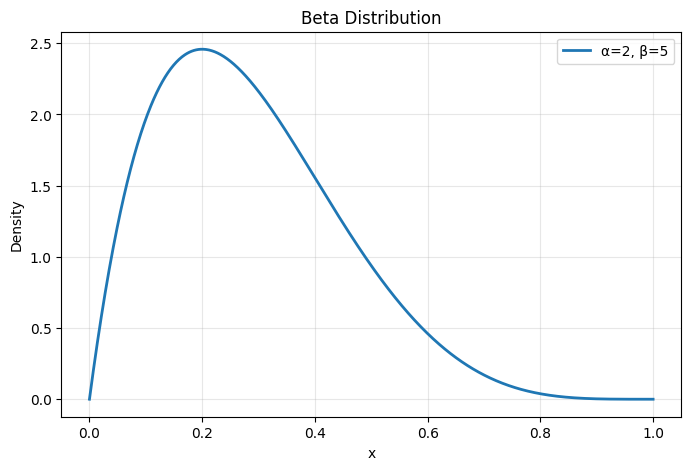

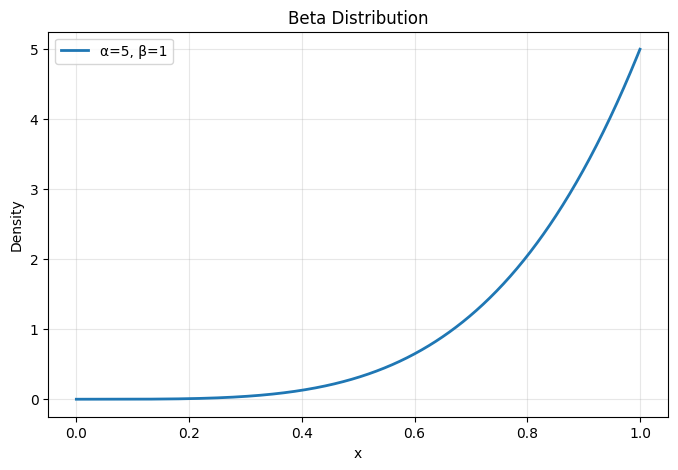

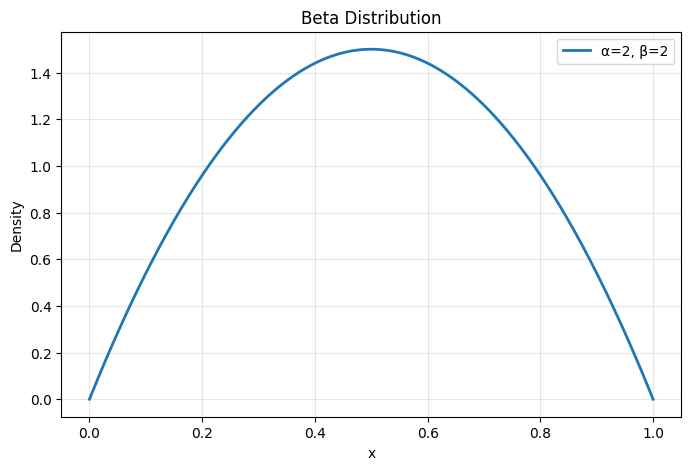

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_distribution(alpha, beta_param):
    x = np.linspace(0, 1, 1000)  # 在 [0, 1] 区间内生成 1000 个点
    y = beta.pdf(x, alpha, beta_param)  # 计算 Beta 分布的概率密度函数值

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f'α={alpha}, β={beta_param}', lw=2)
    plt.title('Beta Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# 示例1：α = 2, β = 5
plot_beta_distribution(2, 5)

# 示例2：α = 5, β = 1
plot_beta_distribution(5, 1)

# 示例3：α = 2, β = 2
plot_beta_distribution(2, 2)



In [29]:
# beta分布测试
# 当数字小的时候，beta分布的概率有很大的随机性
# 当数字大的时候，beta分布逐渐稳定

for _ in range(5):
  print(np.random.beta(1,1))

print("\nnext\n")
for _ in range(5):
  print(np.random.beta(1e5,1e5))



0.7684651413931356
0.7216503424961016
0.7607655409845531
0.7647038904336835
0.7896924202903911

next

0.49887496846640456
0.5009234418102091
0.4992499594231438
0.49938520876290354
0.4997708538047278


In [45]:
import random

def choose_one_beta():

  count_1 = [sum(i)+1 for i in bandit.rewards ]  # 每台老虎机中奖的次数+1 #不中奖的次数+1
  count_0 = [sum(1-np.array(i))+1 for i in bandit.rewards]

  beta = np.random.beta(count_1,count_0)

  return beta.argmax()

output = bandit.get_result(choose_one_beta)
output


(4790.644805233537, 4736)

代码参考出处:

【强化学习 简明教程 代码实战】https://www.bilibili.com/video/BV1Ge4y1i7L6?p=3&vd_source=50ccb4a0dc93b4745397a92264560c6e